<a href="https://colab.research.google.com/github/NikethML/dev/blob/main/multi_class_classification_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License Status Prediction - Multiclass Classification
<hr style="border:1px solid gray"> </hr>

## Contents.

    1. Problem Description
    2. Data Exploration
    3. Feature Selection
    4. KNN Algorithm
    5. Naive Bias
    5. Logistic Regression
    6. Decisoin Tree
    
    
--------------------------------------------------------------------------------------------------------------------------------


### Problem Description

We are given a license dataset which holds various information related the business license , The objective of out problem is to predict license Status for the given business. Lets start with delving deep into the data.
________________________________________________________________________________________________________________________________

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import category_encoders as ce

In [6]:
!pip install category_encoders



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.5 MB/s 


In [9]:
# read the df
url='https://github.com/NikethML/dev/blob/main/input/License_Data.csv?raw=true'
df = pd.read_csv(url)

# print the shape of the dataframe
print(df.shape)

# show the top few rows
display(df.head().T)

(85895, 32)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1,2,3,4
ID,35342-20020816,1358463-20051116,1980233-20090722,1476582-20040211,1141408-20080516
LICENSE ID,1256593,1639294,1980233,1476582,1896750
ACCOUNT NUMBER,32811,262311,345008,273121,213785
SITE NUMBER,1,29,1,1,1
LEGAL NAME,CARMEN CAHUE,"ISLA TROPICAL, INC.",DJS REMODELING,ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
DOING BUSINESS AS NAME,CLAUDIA'S BRIDAL SHOP,ISLA TROPICAL,"DJS REMODELING, INC.",ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
ADDRESS,2625 S CENTRAL PARK AVE 1,2825 W MONTROSE AVE,1605 CLAVEY RD 1,8 NORTH TRAIL,4081 JOSEPH DR
CITY,CHICAGO,CHICAGO,HIGHLAND,LEMONT,WAUKEGAN
STATE,IL,IL,IL,IL,IL
ZIP CODE,60623.0,60618,60035,60439,60087


In [10]:
# change the columns name
new_col_name = [col.replace(" ","_").lower() for col in df.columns]
df.columns = new_col_name

## Variable Description

<b>Dependent Variable</b>   <br>
&nbsp;&nbsp;&nbsp;&nbsp;    1. AAI - License status is issued <br>
&nbsp;&nbsp;&nbsp;&nbsp;    2. AAC - License status is cancelled <br>
&nbsp;&nbsp;&nbsp;&nbsp;    3. REV - License status is revoked <br>
&nbsp;&nbsp;&nbsp;&nbsp;    4. REA - License status is revoked and appealed <br>
&nbsp;&nbsp;&nbsp;&nbsp;    5. INQ - License status is in enquiry <br>
    <br>
<b>Independent Variable</b> : <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Timeline of the application status <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Type of business <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Location details of the business <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Payment details <br>
_______________________________________________________________________________________________________________________________

In [11]:
df.columns

Index(['id', 'license_id', 'account_number', 'site_number', 'legal_name',
       'doing_business_as_name', 'address', 'city', 'state', 'zip_code',
       'ward', 'precinct', 'ward_precinct', 'police_district', 'license_code',
       'license_description', 'license_number', 'application_type',
       'application_created_date', 'application_requirements_complete',
       'payment_date', 'conditional_approval', 'license_term_start_date',
       'license_term_expiration_date', 'license_approved_for_issuance',
       'date_issued', 'license_status_change_date', 'ssa', 'latitude',
       'longitude', 'location', 'license_status'],
      dtype='object')

## Data Cleansing

1. Missing Values - lot of missing data for particular variables
2. Unique Data - id (no meaning)
3. Data leakage - The AAI alone doesn't have licesnse status change value (as the license are never revoked/cancelled) 


In [12]:
df.isnull().sum()

id                                       0
license_id                               0
account_number                           0
site_number                              0
legal_name                               0
doing_business_as_name                   1
address                                  0
city                                     0
state                                    0
zip_code                                31
ward                                 49701
precinct                             56701
ward_precinct                        49700
police_district                      54012
license_code                             0
license_description                      0
license_number                           1
application_type                         0
application_created_date             64660
application_requirements_complete      214
payment_date                          1289
conditional_approval                     0
license_term_start_date                228
license_ter

In [13]:
# Drop columns which are not relevent for the prediction / too many missing values
drop_col_list = ["id","license_id","ssa","location","application_created_date","account_number","address"]
df = df.drop(drop_col_list, axis=1)

In [14]:
df["license_status_change"] = np.where(df.license_status_change_date.isnull(),1,0)

In [15]:
pd.crosstab(df.license_status_change,df.license_status)

license_status,AAC,AAI,INQ,REA,REV
license_status_change,,,,,
0,30200,0,2,3,290
1,0,55400,0,0,0


## Data Transformation
1. Timeline creation
2. Encoding
3. New Feature

In [16]:
# convert string object into date
df.application_requirements_complete = pd.DatetimeIndex(df.application_requirements_complete)
df.payment_date = pd.DatetimeIndex(df.payment_date)
df.license_term_start_date = pd.DatetimeIndex(df.license_term_start_date)
df.license_term_expiration_date = pd.DatetimeIndex(df.license_term_expiration_date)
df.license_approved_for_issuance = pd.DatetimeIndex(df.license_approved_for_issuance)
df.date_issued = pd.DatetimeIndex(df.date_issued)

In [17]:
# Find no.of days btw different application status date
df["completion_to_start"] = (df.license_term_start_date - df.application_requirements_complete).dt.days
df["start_to_expiry"] =  (df.license_term_expiration_date - df.license_term_start_date).dt.days
df["approval_to_issuance"] = (df.date_issued - df.license_approved_for_issuance).dt.days
df["completion_to_payment"] = (df.payment_date - df.application_requirements_complete).dt.days

df["presence_of_enquiry_details"] = np.where(df.ward.isnull() | df.ward_precinct.isnull() | df.police_district | df.precinct , 0 ,1 )

df["target"] = df[['license_status']].apply(lambda col:pd.Categorical(col).codes)

In [18]:
df.city.unique()

array(['CHICAGO', 'HIGHLAND', 'LEMONT', ..., 'ABERDEEN', 'PENSACOLA',
       'MACHESNEY PARK'], dtype=object)

In [19]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))
print(y_onehot.columns)

Index(['target_1', 'target_2', 'target_3', 'target_4', 'target_5'], dtype='object')


## Target Encoding

In [20]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))

class_names=y_onehot.columns
for class_ in class_names:
  enc=ce.TargetEncoder(smoothing=0)
  temp = enc.fit_transform(df[["license_description","state","city"]],y_onehot[class_])
  temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
  df = pd.concat([df,temp],axis=1)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


### Class Imbalance 

In [21]:
df.license_status.value_counts()

AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: license_status, dtype: int64

In [22]:
df.license_status.value_counts(normalize=True).mul(100).round(3).astype(str) + '%'

AAI    64.497%
AAC    35.159%
REV     0.338%
REA     0.003%
INQ     0.002%
Name: license_status, dtype: object

## over sampling/under sampling

In [23]:
np.sort(df.target.unique()).tolist()

[0, 1, 2, 3, 4]

In [24]:
# Undersampling
df_0 = df[df.target==0].sample(frac=0.3,replace=False)
df_1 = df[df.target==1].sample(frac=0.3,replace=False)
# oversamplig
df_2 = df[df.target==2].sample(frac=200,replace=True)
df_3 = df[df.target==3].sample(frac=100,replace=True)
df_4 = df[df.target==4].sample(frac=2,replace=True)

sampled_df = pd.concat([df_0,df_1,df_2,df_3,df_4])

sampled_df.target.value_counts()

1    16620
0     9060
4      580
2      400
3      300
Name: target, dtype: int64

## Train / Test Data Preparation

In [25]:
X = sampled_df[['latitude', 'longitude',
       'completion_to_start',
       'start_to_expiry', 'approval_to_issuance', 'completion_to_payment',
       'presence_of_enquiry_details',  'license_description_target_1',
       'state_target_1', 'city_target_1', 'license_description_target_2',
       'state_target_2', 'city_target_2', 'license_description_target_3',
       'state_target_3', 'city_target_3', 'license_description_target_4',
       'state_target_4', 'city_target_4', 'license_description_target_5',
       'state_target_5', 'city_target_5']]

y = sampled_df['target']

In [26]:
# mean imputation
X = X.fillna(X.mean())

In [27]:
# Train/test preparation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

## Modeling

In [28]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

In [29]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
knn_model.fit((scaler.transform(X_train)),y_train)
scaler.fit(X_test)
y_pred = knn_model.predict(scaler.transform(X_test))

In [30]:
# Metrics Performance
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       904
           1       0.86      0.89      0.88      1657
           2       0.00      0.00      0.00        41
           3       1.00      0.36      0.53        36
           4       0.24      0.38      0.29        58

    accuracy                           0.81      2696
   macro avg       0.57      0.47      0.49      2696
weighted avg       0.80      0.81      0.80      2696



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# Metrics Performance
print(classification_report(y_test,y_pred))

In [34]:
# Metrics Performance
print(confusion_matrix(y_test,y_pred))

[[ 555  344    2    3    0]
 [ 143 1495    0   18    1]
 [   0   41    0    0    0]
 [  36    0    0    0    0]
 [  55    2    0    1    0]]


In [35]:
# Naive Bias
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
y_pred = nb_model.fit(X_train, y_train).predict(X_test)

In [36]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.37      0.47       904
           1       0.91      0.86      0.88      1657
           2       1.00      1.00      1.00        41
           3       0.26      1.00      0.41        36
           4       0.11      0.79      0.20        58

    accuracy                           0.70      2696
   macro avg       0.58      0.81      0.59      2696
weighted avg       0.79      0.70      0.73      2696



In [37]:
print(confusion_matrix(y_test,y_pred))

[[ 335  148    0   90  331]
 [ 189 1432    0    6   30]
 [   0    0   41    0    0]
 [   0    0    0   36    0]
 [   5    0    0    7   46]]


In [38]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=0)
y_pred = dt_model.fit(X_train, y_train).predict(X_test)

In [39]:

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier()

DecisionTreeClassifier()

In [40]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       904
           1       0.90      0.89      0.89      1657
           2       1.00      1.00      1.00        41
           3       0.95      1.00      0.97        36
           4       0.76      0.95      0.85        58

    accuracy                           0.86      2696
   macro avg       0.88      0.93      0.90      2696
weighted avg       0.86      0.86      0.86      2696



In [41]:
print(confusion_matrix(y_test,y_pred))

[[ 718  170    0    2   14]
 [ 176 1478    0    0    3]
 [   0    0   41    0    0]
 [   0    0    0   36    0]
 [   2    1    0    0   55]]


In [42]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, dt_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

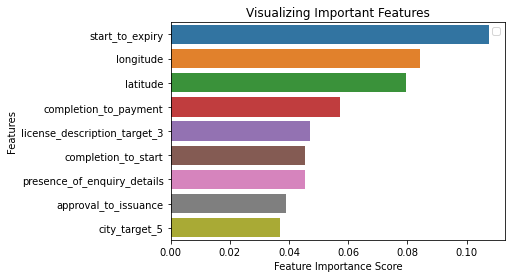

In [43]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [44]:
# Random Tree
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=1)
y_pred = rf_model.fit(X_train, y_train).predict(X_test)

In [45]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [46]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       904
           1       0.92      0.92      0.92      1657
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        36
           4       0.93      0.97      0.95        58

    accuracy                           0.90      2696
   macro avg       0.94      0.95      0.94      2696
weighted avg       0.90      0.90      0.90      2696



In [47]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, rf_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

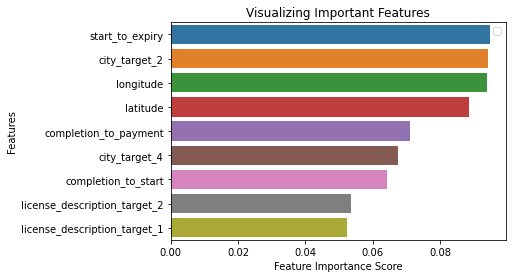

In [48]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [49]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(random_state=0)
ada_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=0)

In [50]:
y_pred = ada_model.predict(X_test)

In [51]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.85      0.76       904
           1       0.90      0.81      0.85      1657
           2       0.63      1.00      0.77        41
           3       0.62      0.36      0.46        36
           4       0.00      0.00      0.00        58

    accuracy                           0.80      2696
   macro avg       0.57      0.60      0.57      2696
weighted avg       0.80      0.80      0.80      2696



In [52]:
# xg Boost
from xgboost import XGBClassifier

In [53]:
X_train.shape

(24264, 22)

In [54]:
xg_model = XGBClassifier(random_state=1)
xg_model.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob', random_state=1)

In [55]:
y_pred = xg_model.predict(X_test)

In [56]:
from sklearn import metrics
metrics.f1_score(y_test,y_pred,average="macro")

0.8483133565534761

In [57]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       904
           1       0.92      0.91      0.92      1657
           2       1.00      1.00      1.00        41
           3       0.97      1.00      0.99        36
           4       0.72      0.40      0.51        58

    accuracy                           0.88      2696
   macro avg       0.88      0.83      0.85      2696
weighted avg       0.88      0.88      0.88      2696



In [58]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, xg_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

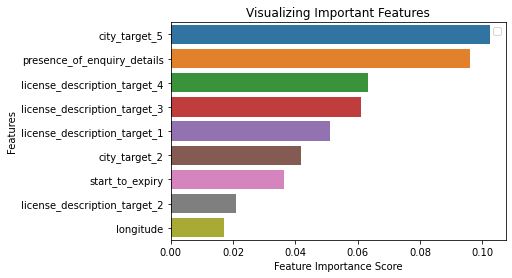

In [59]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [62]:
# Hyperparameter Tuning - Tree parameters
'''
1. No. of trees
2. Depth of the trees
3. Min no. of samples in the leaf node
4. Max number of features
5. Split Criterion 
'''

'\n1. No. of trees\n2. Depth of the trees\n3. Min no. of samples in the leaf node\n4. Max number of features\n5. Split Criterion \n'

In [63]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [64]:
#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,10]

In [65]:
n_estimators

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

In [66]:
max_depth

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]

In [67]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_leaf':[1]
               }
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10, 15, 20], 'min_samples_leaf': [1]}


In [68]:
rf_random = RandomizedSearchCV(estimator = rf_model, 
                               param_distributions = random_grid, n_iter = 10, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)

In [69]:
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [70]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50}

In [74]:
rf_model_tuned = RandomForestClassifier(**rf_random.best_params_)

In [75]:
rf_model_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=5,
                       n_estimators=1400)

In [76]:
y_pred = rf_model_tuned.predict(X_test)

In [77]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       904
           1       0.92      0.92      0.92      1657
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        36
           4       0.89      0.86      0.88        58

    accuracy                           0.90      2696
   macro avg       0.93      0.93      0.93      2696
weighted avg       0.90      0.90      0.90      2696



In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [50,100,150,None],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2,4,5,6],
    'n_estimators': [50,100,150,200]
}

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [80]:
4*3*4*4*3

576

In [81]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150, None],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 4, 5, 6],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=2)

In [82]:
grid_search.best_params_

{'max_depth': 50,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

In [83]:
rf_grid_tuned = RandomForestClassifier(**grid_search.best_params_)

In [84]:
rf_grid_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=3, n_estimators=150)

In [85]:
y_pred = rf_grid_tuned.predict(X_test)

In [86]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       904
           1       0.92      0.92      0.92      1657
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        36
           4       0.86      0.62      0.72        58

    accuracy                           0.89      2696
   macro avg       0.92      0.88      0.90      2696
weighted avg       0.89      0.89      0.89      2696



In [87]:
# Hyper paramater tuning using hyper opt

In [88]:
from hyperopt import hp,fmin,tpe,Trials

In [89]:
# Create the parameter grid based on the results of random search 
param_grid_space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }

In [90]:
def optimize(param_grid_space):
    X_train,y_train,X_test,y_test
    xgbm = XGBClassifier(n_estimators =param_grid_space['n_estimators'], max_depth = int(param_grid_space['max_depth']),
                         gamma = param_grid_space['gamma']
                        )
    xgbm.fit(X_train, y_train)
    y_pred = xgbm.predict(X_test)
    f1score = metrics.f1_score(y_test,y_pred,average="macro")
    return -1*f1score

In [91]:
trial = Trials()
result = fmin(fn=optimize,space=param_grid_space,max_evals=3,trials=trial,algo=tpe.suggest)


100%|██████████| 3/3 [02:06<00:00, 42.20s/it, best loss: -0.925741579146839]


In [92]:
print(result)

{'colsample_bytree': 0.6829234158130091, 'gamma': 1.688271705951382, 'max_depth': 18.0, 'min_child_weight': 1.0, 'reg_alpha': 105.0, 'reg_lambda': 0.023114806276368527}


In [93]:
result["max_depth"] = int(result["max_depth"])

In [94]:
xg_model = XGBClassifier(**result)
xg_model.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.6829234158130091, gamma=1.688271705951382,
              max_depth=18, min_child_weight=1.0, objective='multi:softprob',
              reg_alpha=105.0, reg_lambda=0.023114806276368527)

In [95]:
y_pred = xg_model.predict(X_test)

In [96]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       904
           1       0.91      0.91      0.91      1657
           2       1.00      1.00      1.00        41
           3       0.97      1.00      0.99        36
           4       0.69      0.19      0.30        58

    accuracy                           0.87      2696
   macro avg       0.87      0.79      0.80      2696
weighted avg       0.87      0.87      0.87      2696

